In [1]:
import pytorch_lightning as pl
from torch.nn import functional as F
from torch import nn
import torch

In [2]:
class DeepChromModel(pl.LightningModule):

    def __init__(self, n_features, sequence_length):

        super().__init__()

        self.conv1d = nn.Conv1d(
            in_channels=n_features,
            out_channels=7,
            kernel_size=(3,),
            stride=(1,),
            padding="same",
        )

        self.n_features = n_features
        self.sequence_length = sequence_length

        self.layer_dim = 2
        self.hidden_dim = 20

        self.rnn = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.layer_dim,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )

        self.linear = nn.Linear((2 * self.hidden_dim) * sequence_length + 3 + 1, 42)
        self.linear_2 = nn.Linear(42, 42)
        self.linear_3 = nn.Linear(42, 1)

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=1e-3
        )

        return optimizer

    def training_step(self, batch, batch_idx):

        chromatograms, peakgroup_boundaries, scores, labels = batch

        y_hat = self(chromatograms, peakgroup_boundaries, scores)

        loss = F.binary_cross_entropy(
            y_hat,
            labels
        )

        self.log(
            "train_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

        return loss

    def validation_step(self, batch, batch_idx):

        chromatograms, peakgroup_boundaries, scores, labels = batch

        y_hat = self(chromatograms, peakgroup_boundaries, scores)

        loss = F.binary_cross_entropy(
            y_hat,
            labels
        )

        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        chromatograms, peakgroup_boundaries, scores = batch

        return self(chromatograms, peakgroup_boundaries, scores)

    def forward(self, chromatogram, peakgroup, score):

        batch_size, seq_len, _ = chromatogram.size()

        out = self.conv1d(chromatogram)

        out = out.permute(0, 2, 1)

        out, _ = self.rnn(out)

        out = out.contiguous().view(batch_size, -1)

        out = torch.cat((out, peakgroup, score), 1)

        out = self.linear(out)

        out = F.relu(out)

        out = self.linear_2(out)

        out = F.relu(out)

        out = self.linear_3(out)

        out = torch.sigmoid(out)

        return out

In [3]:
import numpy as np

import glob

training_data_files = glob.glob("/home/aaron/projects/ghost/data/spike_in/chromatograms/*.npz")

In [4]:
chrom_tensors = []
peakgroup_boundary_tensors = []
label_tensors = []
score_tensors = []

for training_data_file in training_data_files:

    chrom_training_data_file = np.load(training_data_file)

    chrom_tensors.append(
        torch.from_numpy(chrom_training_data_file["chromatograms"]).type(torch.FloatTensor)
    )
    peakgroup_boundary_tensors.append(
        torch.from_numpy(chrom_training_data_file["boundaries"]).type(torch.FloatTensor)
    )
    label_tensors.append(
        torch.from_numpy(chrom_training_data_file["labels"]).type(torch.FloatTensor)
    )

    score_tensors.append(
        torch.from_numpy(chrom_training_data_file["scores"]).type(torch.FloatTensor)
    )

chrom_tensors = torch.cat(chrom_tensors, 0)
peakgroup_boundary_tensors = torch.cat(peakgroup_boundary_tensors, 0)
label_tensors = torch.cat(label_tensors, 0)
score_tensors = torch.cat(score_tensors, 0)

In [5]:
chrom_tensors.shape, peakgroup_boundary_tensors.shape, label_tensors.shape, score_tensors.shape

(torch.Size([107692, 7, 175]),
 torch.Size([107692, 3]),
 torch.Size([107692, 1]),
 torch.Size([107692]))

In [6]:
from torch.utils.data import TensorDataset, DataLoader

In [7]:
chrom_dataset = TensorDataset(chrom_tensors, peakgroup_boundary_tensors, score_tensors.reshape(-1, 1), label_tensors)

In [8]:
train_length = int(0.7* len(chrom_dataset))

test_length = len(chrom_dataset) - train_length

train_dataset, test_dataset = torch.utils.data.random_split(
    chrom_dataset,
    (train_length, test_length)
)

In [9]:
validation_length = int(0.1 * len(train_dataset))
validation_length

7538

In [10]:
train_length = len(train_dataset) - validation_length
train_length

67846

In [11]:
train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset,
    (train_length, validation_length)
)

In [12]:
chrom_dataloader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=10
)

In [13]:
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=100,
    num_workers=10
)

In [14]:
trainer = pl.Trainer(
    max_epochs=1,
    gpus=1,
    deterministic=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [15]:
model = DeepChromModel(
    n_features=7,
    sequence_length=175
)

In [16]:
peakgroup_boundary_tensors[0].shape

torch.Size([3])

In [17]:
model(chrom_tensors[0].reshape((1, 7, 175)), peakgroup_boundary_tensors[0].reshape((1, 3)), score_tensors[0].reshape((1, 1)))

tensor([[0.4472]], grad_fn=<SigmoidBackward0>)

In [18]:
label_tensors[0], score_tensors[0]

(tensor([1.]), tensor(0.9766))

In [19]:
trainer.fit(
    model,
    train_dataloaders=chrom_dataloader,
    val_dataloaders=validation_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | conv1d   | Conv1d | 154   
1 | rnn      | LSTM   | 14.6 K
2 | linear   | Linear | 294 K 
3 | linear_2 | Linear | 1.8 K 
4 | linear_3 | Linear | 43    
------------------------------------
310 K     Trainable params
0         Non-trainable params
310 K     Total params
1.243     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [36]:
model(chrom_tensors[3].reshape((1, 7, 175)), peakgroup_boundary_tensors[3].reshape((1, 3)), score_tensors[3].reshape((1, 1)))

tensor([[0.0545]], grad_fn=<SigmoidBackward0>)

In [37]:
label_tensors[0], score_tensors[0]

(tensor([1.]), tensor(0.9766))

In [38]:
trainer.save_checkpoint(
    "test.model"
)

In [39]:
model = DeepChromModel.load_from_checkpoint(
    checkpoint_path="test.model", n_features=7, sequence_length=175
)

In [46]:
trainer = pl.Trainer(gpus=1)

pred_dataset = TensorDataset(
    chrom_tensors,
    peakgroup_boundary_tensors,
    score_tensors.reshape((-1, 1))
)

pred_dataloader = DataLoader(
    pred_dataset,
    num_workers=10,
    batch_size=10000

)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [47]:
%%time

predictions = trainer.predict(
    model,
    dataloaders=pred_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

ValueError: too many values to unpack (expected 2)

In [42]:
predictions = torch.cat(predictions, 0).numpy()

NameError: name 'predictions' is not defined

In [43]:
len(predictions)

NameError: name 'predictions' is not defined

In [67]:
predictions[0], chrom_tensors[0].reshape((1, 7, 175)), peakgroup_boundary_tensors[0].reshape((1, 3)), label_tensors[0], score_tensors[0]

(array([0.9513985], dtype=float32),
 tensor([[[38.8096, 38.8594, 38.9079,  ..., 47.2449, 47.2948,  0.0000],
          [ 0.0000,  5.4858,  5.0009,  ...,  0.8767,  1.0760,  0.0000],
          [ 1.7807,  1.7494,  1.4430,  ...,  0.4250,  0.8082,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.5062,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]),
 tensor([[42.8810, 43.1126, 43.4692]]),
 tensor([1.]),
 tensor(0.9766))

In [60]:
import seaborn as sns

In [61]:
import pandas as pd

In [68]:
test = pd.DataFrame(
    chrom_tensors[0].T.numpy()
)

In [69]:
test

,0,1,2,3,4,5,6
0,38.809586,0.000000,1.780750,0.000000,0.000000,0.00000,0.000000
1,38.859440,5.485782,1.749358,0.000000,0.000000,0.00000,0.000000
2,38.907871,5.000940,1.442997,0.000000,0.000000,0.00000,0.000000
3,38.956299,4.351316,1.259673,0.000000,0.000000,0.00000,0.000000
4,39.006153,1.788122,0.000000,0.000000,0.000000,1.24479,0.328399
...,...,...,...,...,...,...,...
170,47.146622,0.879885,1.132586,0.147499,0.633377,0.00000,0.306697
171,47.196476,1.801184,1.841516,0.256664,1.230467,0.00000,0.000000
172,47.244904,0.876688,0.425028,0.000000,0.000000,0.00000,0.000000
173,47.294758,1.075987,0.808249,0.206082,1.506182,0.00000,0.000000


In [70]:
melted_test = test.melt(id_vars=[0])
melted_test[melted_test[0] > 0]

,0,variable,value
0,38.809586,1,0.000000
1,38.859440,1,5.485782
2,38.907871,1,5.000940
3,38.956299,1,4.351316
4,39.006153,1,1.788122
...,...,...,...
1044,47.098190,6,0.268802
1045,47.146622,6,0.306697
1046,47.196476,6,0.000000
1047,47.244904,6,0.000000


In [71]:
peakgroup_boundary_tensors[0][0]

tensor(42.8810)

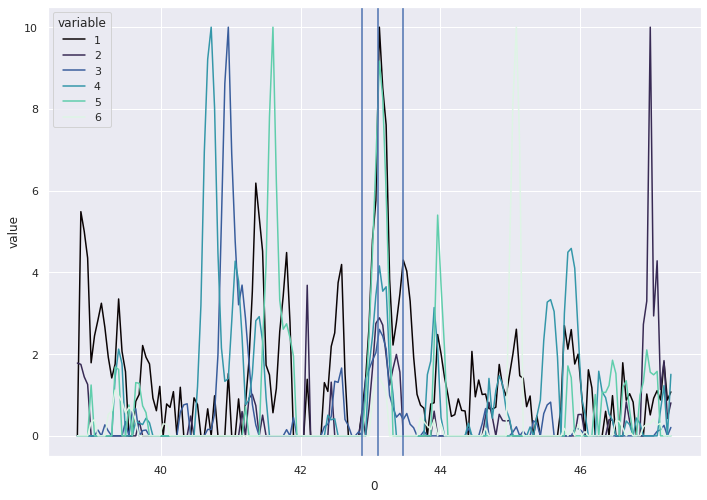

In [72]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=melted_test[melted_test[0] > 0], x=0, y="value", hue="variable", palette="mako")
plt.axvline(peakgroup_boundary_tensors[0][0])
plt.axvline(peakgroup_boundary_tensors[0][1])
plt.axvline(peakgroup_boundary_tensors[0][2])